# Chemistry – Compound Lookups

Several Python packages exist that simplify the process of looking compounds and their chemical structure.

This means that we can look-up compounds by name or structure and create a generative sequence of steps that allows us obtain the structure of a compound, and various properties of it, simply by starting with its common name.

With a representation of the structure to hand, we can then visualise its structure as demonstrated in a later section.

This allows us in part to create one-piece generative document workflows where *information rich* outputs, as well as rich media outputs, can be generated from (potentially hidden) generative scripts contained within the source document.

For creators of educational materials, this means we can create narratives where a compuns is identified by name, a lookup is made, and informational descriptions can then be generated from the looked up object.

This means that the materials will be factually correct as the informational properties will be rendered directly from the retrieved object.

```{warning}
One of the risks associated with generative documents is that if for some reason the generative code cannot be run or fails to execute as intended, the rendered document will be incomplete at best, meaningless at worst.

It is therefore recommended that generative documents should be saved in an archived form with all cells run.

Using a "loop back" generative method, where assets are created, saved to disk, and then loaded back in is another approach that can be used to generate assets that can be persisted for local use by the generating document, or even reused elsewhere.
```

Through being able to look up properties of materials, we can also generate factual statements about them or generate quizzes or opportunities for self-text activities around them.

## `pubchempy`

The [`pubchempy`](https://pubchempy.readthedocs.io/en/latest/) package provides a Python interface to [PubChem](https://pubchem.ncbi.nlm.nih.gov/), a  freely accessible chemical information lookup service. *PubChem* allows for the searching of chemicals by name, lookups of molecular formulas and structures using conventional representations such as a SMILES representation. (Chemicals can also be looked up via their SMILES string.)


:::{admonition} SMILES
:class: tip
SMILES ([*Simplified molecular-input line-entry system*](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system)) is a simple text format for desctibing molecular structure.

Related: [SMILES tutorial](https://www.epa.gov/sites/production/files/2015-05/documents/appendf.pdf(
:::

Packages like `pubchempy` can be used in conjunction with visualisers such as `py3Dmol` to look up a molecule by name (using `pubchempy`) and then display its structure as an interactive 3D model (using `py3Dmol`).

In [1]:
%%capture
try:
    import pubchempy as pcp
except:
    %pip install --upgrade pubchempy

Import the base package:

In [2]:
import pubchempy as pcp

We can look up a chemical by name, select the first result, and then generate the canonical or isomeric SMILES representation:

In [3]:
ethanol = pcp.get_compounds('ethanol', 'name')[0]

ethanol.canonical_smiles, ethanol.isomeric_smiles

('CCO', 'CCO')

If we create a reference to the `.iupac_name` of the compound, we can use that in a markdown field.

In [4]:
from myst_nb import glue

glue("g_ethanol", ethanol.iupac_name, display=False)

Such a reference is embedded in this piece of text: *you looked up the compound {glue:text}`g_ethanol`*.

We can also look up compounds by formula.

```{note}
If required, responses from look-ups can be returned as *pandas* dataframes.
```

In [5]:
nitric_acid_df = pcp.get_compounds('HNO3', 'formula', as_dataframe=True)[:3]

nitric_acid_df[['iupac_name', 'molecular_formula', 'canonical_smiles', 'inchi']]

,iupac_name,molecular_formula,canonical_smiles,inchi
cid,,,,
944,nitric acid,HNO3,[N+](=O)(O)[O-],"InChI=1S/HNO3/c2-1(3)4/h(H,2,3,4)"
123349,hydroxy nitrite,HNO3,N(=O)OO,InChI=1S/HNO3/c2-1-4-3/h3H
12025424,deuterio nitrate,HNO3,[N+](=O)(O)[O-],"InChI=1S/HNO3/c2-1(3)4/h(H,2,3,4)/i/hD"


Round tripping of looking up a compound by name, obtaining its SMILES representation, looking the compound by SMILES representation, and then displaying the name of the final object retrieved, is also supported and can be used as an integrity check:

In [6]:
#Look up by SMILES string
compound = pcp.get_compounds('CCO', 'smiles')[0]
compound.iupac_name

'ethanol'

We can also use other chemcial reference codes for the lookup, such as an `InChI` identifier:

:::{admonition} InChI
:class: tip
`InChI`, the IUPAC ([*International Chemical Identifier*](https://en.wikipedia.org/wiki/International_Chemical_Identifier)) is a  standardised textual identifier for chemical substances. 

The `InChIKey` reference scheme is a condensed 27 character hashed version of the full `InChI` identifier string.
:::

In [7]:
pcp.get_compounds("InChI=1S/HNO3/c2-1(3)4/h(H,2,3,4)","inchi",
                  as_dataframe=True).iloc[0]['iupac_name']

'nitric acid'

The retrieved object stores a wide range of useful informational properties associated with the compound.

For example, looking up the chemical formula (this is described as the *molecular formula* altough I think it's actually the *empirical formula*?):

In [9]:
from IPython.display import Latex

_compound_latex = '$\ce{'+compound.molecular_formula+'}$' 

# Save a reference to the Latex equivalent of the compound name and formula
glue("compoundName", compound.iupac_name, display=False)
glue("compoundLatex", Latex(_compound_latex), display=False)

compound.molecular_formula

'C2H6O'

A simple, literally stated formula can be rendered using MathJax if the `mhchem` package is imported.

$$\require{mhchem}$$ 

```{note}
Support for rendering chemical notation using inline LaTeX markup is enabled by including the following installation requirement into a markdown cell: `$$\require{mhchem}$$`.

Formulas can then be rendered using the an inline LaTeX invocation of the form `$\ce{C2H6O}$` to give output of the form $\ce{C2H6O}$ .
```

Embedding the glued reference for the equation of {glue:text}`compoundName` gives us:

```{glue:math} compoundLatex
:label: eq-sym
```


We can also lookup various properties of the compound and use that as the basis of a custom display outputter for the `pubchempy.Compound` object.

```{note}
Remember, we always collapse or completely remove generator code elements included in the original source document from the rendered text.
```

In [10]:
# Create a function to display compound properties
def pcp_compound_properties(compound):
    """Display various compound properties."""
    properties = []
    properties.append(f'Name: <strong>{compound.iupac_name}</strong>')
    properties.append(f'Formula: <strong>{compound.molecular_formula}</strong>')
    properties.append(f'Common synonyms: <strong>{", ".join(compound.synonyms[:3])}</strong>')
    properties.append(f'SMILES: <strong>{compound.canonical_smiles}</strong>')
    properties.append(f'cid:  <strong>{compound.cid}</strong>')
    properties.append(f'inchi:  <strong>{compound.inchi}</strong>')
    properties.append(f'Molecular weight: <strong>{compound.molecular_weight}</strong>')

    return '<br/>'.join(properties)

# Get a reference to the Compound class
from pubchempy import Compound

# Create a custom formatter for the class
# https://ipython.readthedocs.io/en/stable/config/integrating.html 
html_formatter = get_ipython().display_formatter.formatters['text/html']
html_formatter.for_type(Compound, pcp_compound_properties);

That code can easily be added to a package or included and hidden within source document.

Now if we call the compound we get a prettified, custom output for it:

In [11]:
compound

Compound(702)

## `chembl_webresource_client`

The [ `chembl_webresource_client`](https://github.com/chembl/chembl_webresource_client) package provides a Python interface to [ChEMBL](https://www.ebi.ac.uk/chembl/), a "*manually curated chemical database of bioactive molecules with drug-like properties maintained by the European Bioinformatics Institute (EBI), of the European Molecular Biology Laboratory (EMBL)*" to support the lookup of bioactive chemical compounds by common name.

In [12]:
%%capture
try:
    import chembl_webresource_client
except:
    %pip install --upgrade chembl_webresource_client

Import the package and create a reference for a molecule lookup:

In [13]:
from chembl_webresource_client.new_client import new_client

molecule = new_client.molecule

From this client, we can look up bioactive compounds in a variety of ways, including by popular name:

In [14]:
aspirin = molecule.search('aspirin')

for r in aspirin:
    pref_name = r['pref_name']
    if pref_name is not None:
        print(pref_name)

ASPIRIN
ASPIRIN DL-LYSINE
ASPIRIN EUGENOL ESTER


We can also look-up syonyms of the compound, which might include trade names:

In [15]:
aspirin = [r for r in aspirin if r['pref_name']=='ASPIRIN'][0]
aspirin['molecule_synonyms'][:5]

[{'molecule_synonym': '8-hour bayer',
  'syn_type': 'TRADE_NAME',
  'synonyms': '8-HOUR BAYER'},
 {'molecule_synonym': 'Acetosalic Acid',
  'syn_type': 'TRADE_NAME',
  'synonyms': 'Acetosalic Acid'},
 {'molecule_synonym': 'Acetylsalic acid',
  'syn_type': 'TRADE_NAME',
  'synonyms': 'ACETYLSALIC ACID'},
 {'molecule_synonym': 'Acetylsalicylic Acid',
  'syn_type': 'INN',
  'synonyms': 'Acetylsalicylic Acid'},
 {'molecule_synonym': 'Acetylsalicylic Acid',
  'syn_type': 'TRADE_NAME',
  'synonyms': 'Acetylsalicylic Acid'}]

As before, we can generae an `_repr_` method on the object to provide us with a summary output from the object in a form we desire:

In [16]:
from IPython.display import HTML

# Create a function to display compound properties
def chembl_wrc_molecule_properties(molecule):
    """Display various compound properties."""
    properties = []
    _wikipedia_name =  [c['xref_id'] for c in molecule['cross_references'] if c["xref_src"]=='Wikipedia']
    _wikipedia_name = '' if not _wikipedia_name else _wikipedia_name[0]
    properties.append(f'Name: <strong>{molecule["pref_name"]}</strong>')
    properties.append(f'Common Wikipedia (common) name: <strong>{_wikipedia_name}</strong>')
    properties.append(f'Formula: <strong>{molecule["molecule_properties"]["full_molformula"]}</strong>')
    properties.append(f'Species: <strong>{molecule["molecule_properties"]["molecular_species"]}</strong>')
    properties.append(f'SMILES: <strong>{molecule["molecule_structures"]["canonical_smiles"]}</strong>')
    properties.append(f'inchi:  <strong>{molecule["molecule_structures"]["standard_inchi"]}</strong>')
    properties.append(f'CHEMBL id:  <strong>{molecule["molecule_chembl_id"]}</strong>')
    properties.append(f'Therapeutic flag: <strong>{molecule["therapeutic_flag"]}</strong>')
    properties.append(f'First approval: <strong>{molecule["first_approval"]}</strong>')

    return HTML('<br/>'.join(properties))

If we call the object, we get a summary review of it:

In [17]:
chembl_wrc_molecule_properties(aspirin)

As well as looking up compounds by name, we can lookup a molecules more specifically from a SMILES string:

In [18]:
from chembl_webresource_client.new_client import new_client

molecule = new_client.molecule
ethanol_chembl = molecule.get(ethanol.canonical_smiles)

chembl_wrc_molecule_properties(ethanol_chembl)

We can also start to visualise the structure of the compound:

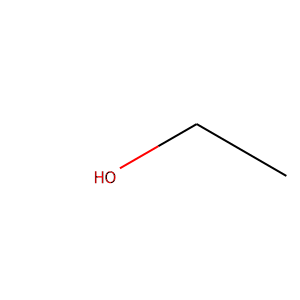

In [19]:
from IPython.display import SVG
from chembl_webresource_client.utils import utils

chembl_smiles = ethanol_chembl["molecule_structures"]["canonical_smiles"]

SVG(utils.smiles2svg(chembl_smiles))

## `pypdb`

The [`pypdb`](https://github.com/williamgilpin/pypdb) package provides simple Python API for performing searches with the *RCSB (Research Collaboratory for Structural Bioinformatics) Protein Data Bank (PDB)* [[about](https://www.rcsb.org/pages/about-us/index)]. 

In [20]:
%%capture
#https://github.com/williamgilpin/pypdb/blob/master/demos/demos.ipynb
try:
    import pypdb
except:
    %pip install pypdb

In [24]:
import pypdb

# Broken?
#pypdb.Query('aspirin').search()

AttributeError: 'NoneType' object has no attribute 'status_code'